# Lab Six: Convolutional Network Architectures

# James Thomas, Xiaoxian Jing, Kuang Yan

 1. [Dataset Selection](#data)<br>
 2. [Preparation](#prep)<br>
  2.1 [Metric](#metric)<br>
  2.2 [Test-Train Split](#split)<br>
 3. [Modeling](#modeling)<br>
  3.1 [CNN](#cnn)<br>
  3.2 [Different Architectures](#architectures)<br>
  3.3 [Visualize Final Results](#visualize)<br>
  3.4 [Compare the Performance](#compare)<br>
 4. [Exceptional Work](#exceptional)<br>
  4.1 [Additional Analyses](#additional_analysis)<br>
  4.2 [Transfer Learning](#Transfer_Learning)<br>
 5. [Final Thoughts](#thoughts)<br>
  
[//]: # (put the html anchors above the titles for better scrolling)
[//]: # (note the <br>, and why do I need .. for 3rd level?, maybe I should just use pureish html)

<a id="data"></a>

## Data Selection

> Select a dataset identically to lab two (images). That is, the dataset must be image data. In terms of generalization performance, it is helpful to have a large dataset of identically sized images. It is fine to perform binary classification or multi-class classification.

For this project we chose to use a [random sample of NIH Chest X-Ray Dataset](https://www.kaggle.com/nih-chest-xrays/sample/home). This dataset contains 5606 images that have been preprocessed to be a uniform size of $1024 \times 1024$ and also includes a csv containing the labels associated with the x-ray images. This dataset includes X Ray images of patients with 14 different diseases.

<a id="preparation"></a>

## Preparation

Before we define the metric and decide on a test-train split, we need to make sure all of the X-Ray images are the same format. The images are all the same size, but we will need to make sure all of them are black and white as well as flipping some of the images along the vertical axis to account for the different persepctives used (patient laying on back or front). While we are doing this we will also resize the images to a smaller size to make our testing run quicker.

In [37]:
import pandas as pd

# first read in the dataframe that gives us the perspective
df = pd.read_csv('sample_labels.csv')

In [50]:
import os
from PIL import Image
import time
from IPython.display import display, clear_output

size = 1024
base = os.getcwd()
full = os.path.join(base,'sample/images/')
t_start = time.time()

size_dict = {64:  '64x64',
             128: '128x128',
             256: '256x256',
             512: '512x512',
             1024:'1024x1024'}

i=0
errors = 0
for (dirpath, dirnames, filenames) in os.walk(full):
    for file in filenames:
        # get the info from the df
        # possibly a more efficient way to do this, but this works
        row = df[df['Image Index']==str(file)]
        if row['View Position'].values[0] == 'PA':
            # flip the PA
            img = Image.open(os.path.join(full, file)).convert('L').transpose(Image.FLIP_LEFT_RIGHT)
        elif row['View Position'].values[0] == 'AP':
            # keep AP
            img = Image.open(os.path.join(full, file)).convert('L')
        else:
            # in case there is an error
            img = Image.open(os.path.join(full, file)).convert('L')
            error += 1
            with open('sample/proj.dat', 'a+') as f:
                f.write('Could not find image {} in the df\n'.format(file))
                f.write(str(row['View Position']=='PA'))
        o_size = img.size
        s = size, size
        img.thumbnail(s)
        img.save(os.path.join(base, 'sample', size_dict[size], file))
        clear_output()
        display('finished #{}: {}: Original Dims ({} {}) : Finial Dims ({} {}): time {:.2f} seconds'.format(i, file, o_size[0], o_size[1], img.size[0], img.size[1], time.time()-t_start))
        i+=1
print('{} files missed, check proj.dat file'.format(errors))

'finished #5605: 00030797_000.png: Original Dims (1024 1024) : Finial Dims (1024 1024): time 1488.72 seconds'

0 files missed, check proj.dat file


'finished #128: 00000733_003.png: size 128: time 1070.45 seconds'

KeyboardInterrupt: 

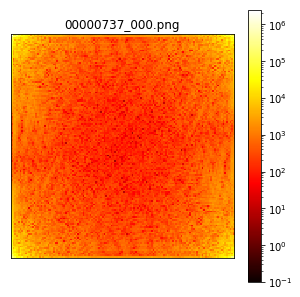

In [8]:
%matplotlib inline
import numpy as np
import os
from PIL import Image
import time
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

base = os.getcwd()
print(base)
t_start = time.time()

size_dict = {64:  '64x64',
             128: '128x128',
             256: '256x256',
             512: '512x512',
             1024:'1024x1024'}

sizes = [64, 128, 256, 512, 1024]
for size in sizes:
  
    read_dir = os.path.join(base, 'sample', size_dict[size])
    write_dir = read_dir+'_fft'
    
    i = 0
    for (dirpath, dirnames, filenames) in os.walk(read_dir):
        for file in filenames:
            # read image
            img = Image.open(os.path.join(read_dir, file))
            fft = np.fft.fft2(img)
            fft_abs = np.abs(fft)
            f, _ = os.path.splitext(file)
            np.save(write_dir+'/'+f+'.fft', fft)
        
            fig, ax = plt.subplots(figsize=(5,5))
            im = ax.imshow(fft_abs, cmap='hot', norm=LogNorm(vmin=0.1))
            ax.set(xticks=[], yticks=[], title=file)
            cb = fig.colorbar(im)
            fig.savefig(os.path.join(write_dir, file))
            plt.close(fig)
        
            clear_output()
            display('finished #{}: {}: size {}: time {:.2f} seconds'.format(i, file, size, time.time()-t_start))
            i+=1

<a id="Metric"></a>

### Metric

> __[15 points]__ Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a __detailed argument for why this (these) metric(s) are appropriate__ on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.

For this project we chose to use two metrics. 

- First, the F1 score. This metric allows us to account for false positives as well as false negatives, which improves over a simple accuracy. Although a more in-depth metric, such as a custom cost matrix, may allow for finer tuning of the performace of our model, it removes the ability for us to compare our model with others.  

- Second, Recall. This metric emphesizes captureing all of the X Rays with a disease without much regard for false positives. In this situation, this is okay because the false positives will likley just have additional screenings or tests, while a false negative could have serioius health consequences for the patient.

<a id="split"></a>

### Test-Train Split

> __[15 points]__ Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). __Explain why your chosen method is appropriate or use more than one method as appropriate__. Convince me that your cross validation method is a realistic mirroring of how an algorithm would be used in practice. 

For this project we will use 70% of the data for training, 10% for validation, and the remaining 20% for testing. Since we also have a class imbalance, we will use stratification at each splitting to ensure that all of the labels are represented appropriately in the sub-samples. 

In [46]:
cwd = os.getcwd()
full = os.path.join(cwd, 'sample', '64x64')
#print(cwd)
#print(full)
img = Image.open(os.path.join(full, '00000013_005.png'))
img.size

D:\Courses\SMU\Machine_Learning\MachineLearningPython\Lab6
D:\Courses\SMU\Machine_Learning\MachineLearningPython\Lab6\sample\64x64


(64, 64)

<a id="Modeling"></a>

## Modeling

<a id="cnn"></a>

### CNN

> __[15 points]__ Create a convolutional neural network to use on your data using Keras. Setup the training to use data expansion in Keras. Explain why the chosen data expansion techniques are appropriate for your dataset. 

In [42]:
# Convolutional Neural Network
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input, Dense, Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D

visible = Input(shape=(64,64,1))
conv1 = Conv2D(32, kernel_size=4, activation='relu')(visible)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(16, kernel_size=4, activation='relu')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
flat = Flatten()(pool2)
hidden1 = Dense(10, activation='relu')(flat)
output = Dense(1, activation='sigmoid')(hidden1)
model = Model(inputs=visible, outputs=output)
# summarize layers
print(model.summary())

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 32)        544       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 27, 16)        8208      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2704)              0         
_________________________________________________________________
dens

ImportError: Failed to import `pydot`. Please install `pydot`. For example with `pip install pydot`.

<a id="architectures"></a>

### Different Architectures

> __[20 points]__ Investigate at least two different convolutional network architectures (and investigate changing some parameters of each architecture). Use the method of cross validation and evaluation metric that you argued for at the beginning of the lab. Visualize the performance of the training and validation sets per iteration (use the "history" parameter of Keras).

<a id="visualize"></a>

### Visualize Final Results

> __[15 points]__ Visualize the final results of the CNNs and interpret the performance. Use proper statistics as appropriate, especially for comparing models. 

<a id="compare"></a>

### Compare the Perfomace

> __[10 points]__ Compare the performance of your convolutional network to a standard multi-layer perceptron (MLP) using the receiver operating characteristic and area under the curve. Use proper statistical comparison techniques.  

<a id="exceptional"></a>

## Exceptional Work

<a id="additional_analyses"></a>

### Additional Analyses

> You have free reigh to provide additional analyses.

In addition to simply predicting whether or not a patient has one of the conditions, it may also be useful to know which sections of the X Ray were most indicative of the condition. To extract this information we will add heatmaps to the images using class activation mappings (CAMs).

In [ ]:
import keras.backend as K

get_layer = K.function(
    [model.layers[0].input, K.learning_phase()],
    [model.layers[LAYER_DESIRED].output])
layer_output = get_layer([x_test, 0])[0]

<a id="Transfer_Learning"></a>

### Transfer Learning

> One idea (__required for 7000 level students__): Use transfer learning to pre-train the weights of your initial layers of your CNN. Compare the performance when using transfer learning to training from scratch in terms of classification performance.

<a id="thoughts"></a>

## Final Thoughts